# WOfS Collection Upgrade Testing

Preliminaries:

In [1]:
import datacube
import matplotlib.pyplot as plt, cartopy.crs, numpy as np, pandas, datetime

In [2]:
dc = datacube.Datacube()

## Locating the sample data

First step is confirming access to new and old datasets.

In [3]:
[n for n in dc.list_products().name.to_list() if 'wo' in n.lower()]

['ga_ls_wofs_3',
 'sentinel2_wofs_nrt',
 'wofs_albers',
 'wofs_annual_summary',
 'wofs_apr_oct_summary',
 'wofs_filtered_summary',
 'wofs_nov_mar_summary',
 'wofs_summary']

In [4]:
[dc.index.datasets.count(product=i) for i in ['ga_ls_wofs_3', 'wofs_summary', 'wofs_albers']]

[17004, 1244, 3069704]

In [5]:
records = dc.find_datasets(product='ga_ls_wofs_3')
len(records)

17004

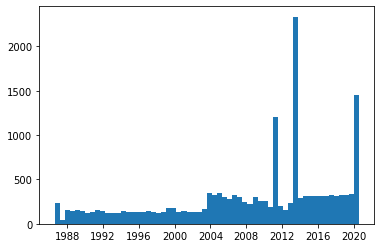

In [6]:
plt.hist([i.key_time for i in records], bins=60); None

In [7]:
set(i.crs for i in records)

{CRS('epsg:32649'),
 CRS('epsg:32650'),
 CRS('epsg:32651'),
 CRS('epsg:32652'),
 CRS('epsg:32653'),
 CRS('epsg:32654'),
 CRS('epsg:32655'),
 CRS('epsg:32656')}

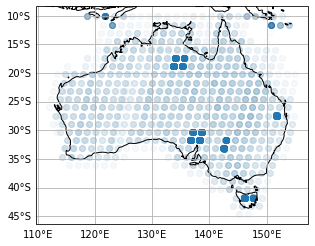

In [8]:
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.scatter(*zip(*[(i.extent.centroid.to_crs('epsg:4326').points)[0] for i in records]), alpha=0.02)
ax.coastlines()
g = ax.gridlines(draw_labels=True); g.top_labels = g.right_labels = False
None

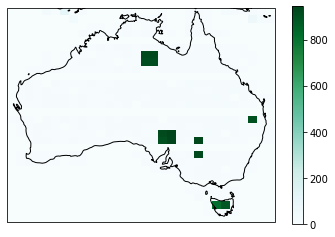

In [9]:
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines()
plt.colorbar(ax.hist2d(*zip(*[(i.extent.centroid.to_crs('epsg:4326').points)[0] for i in records]), 
                       bins=30, cmap='BuGn')[-1])
None

Evidently we have access both to the previous existing WOfS product, and to some samples of the new collection "3" WOFLs.

The new samples appear to have shallow comprehensive coverage, and probably full temporal coverage in a handful of spatial locations (including path/row neighbours). 

## Matching old and new datasets for comparison

Most likely there is a simple time offset. For simplicity, to avoid querying the full archive of old datasets, the analysis is restricted spatially.

In [10]:
lat, lon = -32, 138
lat, lon = -41.8, 147 # Tasmania
lat, lon = -41.8, 146 # Tasmania, more mountainous

In [11]:
new = dc.find_datasets(product='ga_ls_wofs_3', lat=lat, lon=lon)
old = dc.find_datasets(product='wofs_albers', lat=lat, lon=lon)
len(old), len(new)

(713, 819)

In [12]:
t0 = [i.key_time for i in old]
t1 = [i.key_time for i in new]

-0.4877510070800781

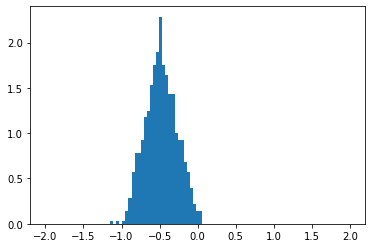

In [13]:
common_dates = set(i.date() for i in t0) & set(i.date() for i in t1)
T0 = np.asarray(sorted(i.timestamp() for i in t0 if i.date() in common_dates))
T1 = np.asarray(sorted(i.timestamp() for i in t1 if i.date() in common_dates))
plt.hist(T0 - T1, bins=np.linspace(-2, 2, 100), density=True)
np.median(T0 - T1) # mean is a poor estimator due to outlying mismatches

This shows that the temporal index of the new product leads that of the old product by a half second, give or take a second. This is as though the old product had truncated the milliseconds. 

It is not too difficult to match most pairs, even without using a tolerance time window. (Those that are missed might also be more likely to contain different extents between versions.)

516

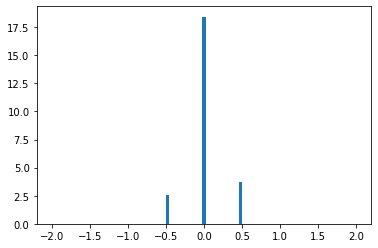

In [14]:
rounding = 0.5
offset = 0.5 # why was this needed?
oldtime = lambda t: datetime.datetime.fromtimestamp(round((t.timestamp() - offset) / rounding) * rounding)
t2 = [oldtime(i) for i in t1]

T2 = np.asarray(sorted(i.timestamp() for i in t2 if i.date() in common_dates))
plt.hist(T0 - T2, bins=np.linspace(-2, 2, 100), density=True)

len(set(t0) & set(t2))

In [15]:
Old = pandas.Series(old)
Old.index = Old.apply(lambda i: i.key_time)

New = pandas.Series(new)
New.index = New.apply(lambda i: oldtime(i.key_time)) # use compatible temporal indexes

table = pandas.DataFrame(dict(old=Old, new=New)).dropna() # combine and only retain index matches
len(table)

516

In [16]:
e = 0.1
spatial = dict(lat=(lat-e, lat+e), lon=(lon-e,lon+e))
x0 = dc.load(datasets=table.old.to_list(), output_crs='epsg:3577', resolution=(25,-25), **spatial)
x1 = dc.load(datasets=table.new.to_list(), output_crs='epsg:3577', resolution=(25,-25), **spatial)

## Compare old and new datasets

Now that comparable example datasets are available (in memory), wish to analyse how (if at all) they differ.

It is immediately obvious that they do not have the same data type and value range.

In [17]:
x0.water.shape, x1.water.shape, x0.water.dtype, x1.water.dtype, x0.water.size, x1.water.size

((516, 938, 773),
 (516, 938, 773),
 dtype('int16'),
 dtype('uint8'),
 374138184,
 374138184)

In [18]:
(x0.water.data == x1.water.data).mean()

0.39582711771541607

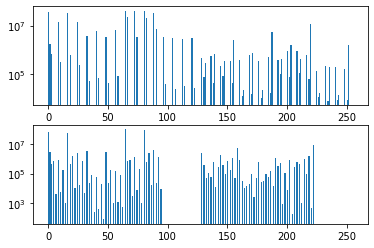

In [19]:
plt.subplot(2, 1, 1).hist(x0.water.data.ravel(), bins=range(256)); plt.yscale('log', nonposy='clip')
plt.subplot(2, 1, 2).hist(x1.water.data.ravel(), bins=range(256)); plt.yscale('log', nonposy='clip')
None

Some potential value differences are:

- Originally the third (least significant) bit was for ocean. This has been repurposed for grazing insolation, which was previously combined into the fourth bit together with terrain shadow.

- The new pixel quality algorithm makes some categories mutually exclusive (viz. python-fmask gives cloud precedence over cloud-shadow).

- For pixels masked as no-data, the other fields are meaningless.

In [20]:
z0 = x0.water.data.copy()
z1 = x1.water.data.copy()

z0[(z0 & 1).astype(np.bool)] = 1 # single flavour of nodata

z0[(z0 & 2).astype(np.bool)] = 2 # Similarly, not concerned here with
z1[(z1 & 2).astype(np.bool)] = 2 # treatment of noncontiguous data.

z0 &= ~np.uint8(4) # disregard ocean

z1[(z1 & 4).astype(np.bool)] |= 8 # bundle insolation with terrain shadow
z1 &= ~np.uint8(4)

z0[(z0 & 64).astype(np.bool)] &= ~np.uint8(32) # precedence of cloud over cloud-shadow

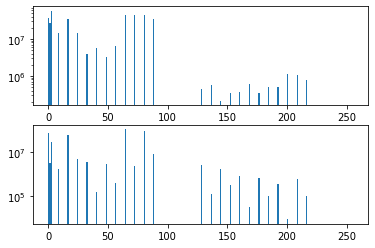

In [21]:
plt.subplot(2, 1, 1).hist(z0.ravel(), bins=range(256)); plt.yscale('log', nonposy='clip')
plt.subplot(2, 1, 2).hist(z1.ravel(), bins=range(256)); plt.yscale('log', nonposy='clip')

In [22]:
u0, c0 = np.unique(z0, return_counts=True)
u1, c1 = np.unique(z1, return_counts=True)

set(u0) ^ set(u1)

set()

# How does the data look, spatially?

Sanity check: clear observation count.

The new version deems more of the observations to be clear.

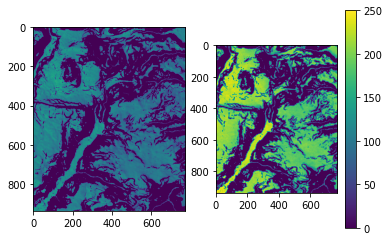

In [34]:
m0 = plt.subplot(1, 2, 1).imshow(((z0 == 0) | (z0 == 128)).sum(axis=0), vmax=250)
m1 = plt.subplot(1, 2, 2).imshow(((z1 == 0) | (z1 == 128)).sum(axis=0), vmax=250)
plt.colorbar(m1); None

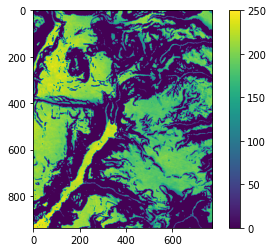

In [31]:
plt.imshow(((z1 == 0) | (z1 == 128)).sum(axis=0), vmax=250)
plt.colorbar(); None

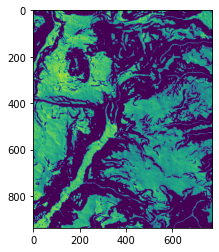

In [26]:
plt.imshow((x0.water.data & ~np.uint8(128) == 0).sum(axis=0))

In [27]:
z0.shape, z1.shape

((516, 938, 773), (516, 938, 773))

## How do the actual values differ?

In [32]:
(z0 == z1).mean()

0.42457662380699424

In [46]:
for bit in range(8):
    x = 2**bit
    print(x, ((z0 & x) == (z1 & x)).mean())

1 0.9269046112652324
2 0.7863863101447031
4 1.0
8 0.7059187628921618
16 0.8998164966770673
32 0.9422213798952955
64 0.7977445814512213
128 0.9893625238743341


Most pixels differ in some manner.

In [57]:
good = ~ ((z0 & 3) | (z1 & 3)).astype(np.bool)
for bit in range(8):
    x = 2**bit
    print(x, ((z0[good] & x) == (z1[good] & x)).mean(), 
          (z0[good] & x).astype(np.bool).mean(), (z1[good] & x).astype(np.bool).mean())
(z0[good] == z1[good]).mean()

1 1.0 0.0 0.0
2 1.0 0.0 0.0
4 1.0 0.0 0.0
8 0.6308438676988295 0.42058683603609887 0.054461885559749255
16 0.9723622788798509 0.47761479178610317 0.47310080381063974
32 0.9265443291420906 0.07282908748930186 0.029119045591551932
64 0.9266463389318097 0.5784488794628583 0.5092071217531761
128 0.9870329206623617 0.023600607782041618 0.025596770573666654


0.5396974580029237

Among the pixels with completely valid data, half still differ.

The differences are usually in terrain insolation (40% -> 5%), and to a lesser extent in cloud (58% -> 51%) and cloud shadow (7% -> 3%).

The water classifier, and the slope, are highly consistent.

In [59]:
vgood = good & ~((z0 & 8) | (z1 & 8)).astype(np.bool)
good.mean(), vgood.mean()

(0.7684637208801975, 0.4440933192747843)

In [63]:
g0 = z0[good] & ~np.uint8(8) # ignore terrain bit
g1 = z1[good] & ~np.uint8(8)
for bit in range(8):
    x = 2**bit
    print(x, ((g0 & x) == (g1 & x)).mean(), 
          (g0 & x).astype(np.bool).mean(), (g1 & x).astype(np.bool).mean())
(g0 == g1).mean()

1 1.0 0.0 0.0
2 1.0 0.0 0.0
4 1.0 0.0 0.0
8 1.0 0.0 0.0
16 0.9723622788798509 0.47761479178610317 0.47310080381063974
32 0.9265443291420906 0.07282908748930186 0.029119045591551932
64 0.9266463389318097 0.5784488794628583 0.5092071217531761
128 0.9870329206623617 0.023600607782041618 0.025596770573666654


0.8355988991484974

In [75]:
(7.28 - 0.291) / 7.28, (57.84 - 50.92) / 57.84

(0.9600274725274724, 0.11964038727524207)

Even ignoring the terrain mask, only ~80% of pixels are identical. The water mask is very consistent, the slope mask is similar, but the cloud and especially cloud shadow are significantly reduced.

This might affect the area of unmasked water.

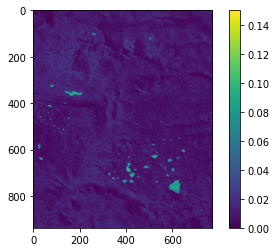

In [44]:
plt.imshow(((z0 & 128) != (z1 & 128)).mean(axis=0), vmax=0.15)
plt.colorbar(); None

/env/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


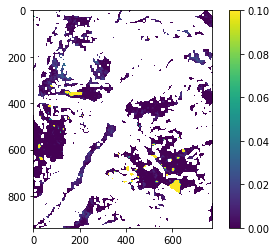

In [73]:
w0 = (z0 == 128).sum(axis=0)
w1 = (z1 == 128).sum(axis=0)
d0 = (z0 == 0).sum(axis=0)
d1 = (z1 == 0).sum(axis=0)
plt.imshow(w0 / (w0 + d0), vmax=0.1); plt.colorbar(); None

/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


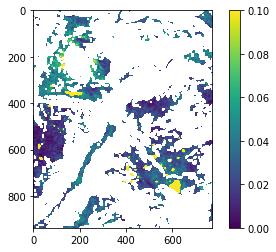

In [74]:
plt.imshow(w1 / (w1 + d1), vmax=0.1); plt.colorbar(); None

/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


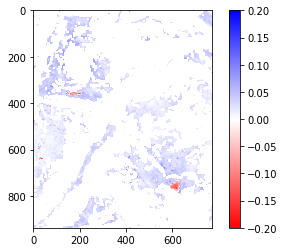

In [83]:
plt.imshow(w1 / (w1 + d1) - w0 / (w0 + d0), vmax=0.2, vmin=-0.2, cmap='bwr_r'); plt.colorbar(); None